In [1]:
import numpy as np
from numpy import ma
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator
from matplotlib import rcParams

In [2]:
import matplotlib
print(f'matplotlib  {matplotlib.__version__}')     # was 2.1.0   :  upgraded to 3.2.0
# ! pip install matplotlib          # left the version at 2.1.0 as 'Requirement already satisfied'
# ! pip install 'matplotlib>=2.2'   # left the version at 2.1.0 as 'Requirement already satisfied'
# ! pip install "matplotlib==2.2"   # worked
# ! pip install "matplotlib==3.2"   # worked, also installed kiwisolver-1.1.0
# AFTER FIRST INSTALLED, must restart kernel in order to load new version.

matplotlib  3.2.0


In [3]:
# BUG: this example fails with any other setting of axisbelow
rcParams['axes.axisbelow'] = False

class MercatorLatitudeScale(mscale.ScaleBase):
    """
    Scales data in range -pi/2 to pi/2 (-90 to 90 degrees) using
    the system used to scale latitudes in a Mercator projection.

    The scale function:
      ln(tan(y) + sec(y))

    The inverse scale function:
      atan(sinh(y))

    Since the Mercator scale tends to infinity at +/- 90 degrees,
    there is user-defined threshold, above and below which nothing
    will be plotted.  This defaults to +/- 85 degrees.

    source:
    http://en.wikipedia.org/wiki/Mercator_projection
    """

    # The scale class must have a member ``name`` that defines the string used
    # to select the scale.  For example, ``gca().set_yscale("mercator")`` would
    # be used to select this scale.
    name = 'mercator'

    def __init__(self, axis, *, thresh=np.deg2rad(85), **kwargs):
        """
        Any keyword arguments passed to ``set_xscale`` and ``set_yscale`` will
        be passed along to the scale's constructor.

        thresh: The degree above which to crop the data.
        """
        super().__init__(axis)
        if thresh >= np.pi / 2:
            raise ValueError("thresh must be less than pi/2")
        self.thresh = thresh

    def get_transform(self):
        """
        Override this method to return a new instance that does the
        actual transformation of the data.

        The MercatorLatitudeTransform class is defined below as a
        nested class of this one.
        """
        return self.MercatorLatitudeTransform(self.thresh)

    def set_default_locators_and_formatters(self, axis):
        """
        Override to set up the locators and formatters to use with the
        scale.  This is only required if the scale requires custom
        locators and formatters.  Writing custom locators and
        formatters is rather outside the scope of this example, but
        there are many helpful examples in ``ticker.py``.

        In our case, the Mercator example uses a fixed locator from
        -90 to 90 degrees and a custom formatter class to put convert
        the radians to degrees and put a degree symbol after the
        value::
        """
        class DegreeFormatter(Formatter):
            def __call__(self, x, pos=None):
                return "%d\N{DEGREE SIGN}" % np.degrees(x)

        axis.set_major_locator(FixedLocator(
            np.radians(np.arange(-90, 90, 10))))
        axis.set_major_formatter(DegreeFormatter())
        axis.set_minor_formatter(DegreeFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        """
        Override to limit the bounds of the axis to the domain of the
        transform.  In the case of Mercator, the bounds should be
        limited to the threshold that was passed in.  Unlike the
        autoscaling provided by the tick locators, this range limiting
        will always be adhered to, whether the axis range is set
        manually, determined automatically or changed through panning
        and zooming.
        """
        return max(vmin, -self.thresh), min(vmax, self.thresh)

    class MercatorLatitudeTransform(mtransforms.Transform):
        # There are two value members that must be defined.
        # ``input_dims`` and ``output_dims`` specify number of input
        # dimensions and output dimensions to the transformation.
        # These are used by the transformation framework to do some
        # error checking and prevent incompatible transformations from
        # being connected together.  When defining transforms for a
        # scale, which are, by definition, separable and have only one
        # dimension, these members should always be set to 1.
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self, thresh):
            mtransforms.Transform.__init__(self)
            self.thresh = thresh

        def transform_non_affine(self, a):
            """
            This transform takes an Nx1 ``numpy`` array and returns a
            transformed copy.  Since the range of the Mercator scale
            is limited by the user-specified threshold, the input
            array must be masked to contain only valid values.
            ``matplotlib`` will handle masked arrays and remove the
            out-of-range data from the plot.  Importantly, the
            ``transform`` method *must* return an array that is the
            same shape as the input array, since these values need to
            remain synchronized with values in the other dimension.
            """
            masked = ma.masked_where((a < -self.thresh) | (a > self.thresh), a)
            if masked.mask.any():
                return ma.log(np.abs(ma.tan(masked) + 1.0 / ma.cos(masked)))
            else:
                return np.log(np.abs(np.tan(a) + 1.0 / np.cos(a)))

        def inverted(self):
            """
            Override this method so matplotlib knows how to get the
            inverse transform for this transform.
            """
            return MercatorLatitudeScale.InvertedMercatorLatitudeTransform(
                self.thresh)

    class InvertedMercatorLatitudeTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self, thresh):
            mtransforms.Transform.__init__(self)
            self.thresh = thresh

        def transform_non_affine(self, a):
            return np.arctan(np.sinh(a))

        def inverted(self):
            return MercatorLatitudeScale.MercatorLatitudeTransform(self.thresh)

# Now that the Scale class has been defined, it must be registered so
# that ``matplotlib`` can find it.
mscale.register_scale(MercatorLatitudeScale)

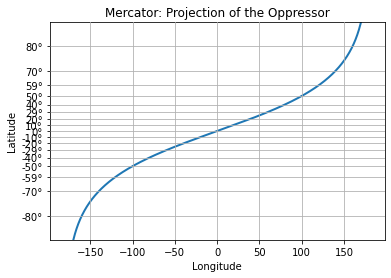

In [6]:
if True : # __name__ == '__main__':
    import matplotlib.pyplot as plt

    t = np.arange(-180.0, 180.0, 0.1)
    s = np.radians(t)/2.

    plt.plot(t, s, '-', lw=2)
    plt.gca().set_yscale('mercator')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Mercator: Projection of the Oppressor')
    plt.grid(True)
    plt.show()
    # Stangely, sometimes only prints:  <Figure size 640x480 with 1 Axes>
    # print('done')